# CR3BP Trajectory Optimization with SCVX

This notebook demonstrates spacecraft trajectory optimization in the Circular Restricted Three-Body Problem (CR3BP) using Sequential Convex Programming (SCVX) with nonlinearity index-based mesh refinement.

## Features:
- CR3BP dynamics with Earth-Moon system
- Nonlinearity index computation for adaptive mesh refinement
- Trust region optimization with mesh adaptation
- 3D trajectory visualization with nonlinearity indicators
- Thrust profile and mass analysis

In [1]:
# Import Required Libraries
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import casadi as ca
import time
import sys
import os

# Add the project root to path for clean package imports
# From experiments/CR3BP/ we need to go up two levels to reach the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', '..'))
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Python path includes: {project_root}")

# Clean package imports - much better!
from dynamics import CR3BPDynamics
from vanilla_dynamics import VanillaCR3BPDynamics  
from convexOPT import CVXProgram

print("Libraries imported successfully!")
print("✨ Using clean package-level imports!")

Project root: /media/potato/New Volume/Auburn/mesh_refinement_nonlinearity_idx_unified
Python path includes: /media/potato/New Volume/Auburn/mesh_refinement_nonlinearity_idx_unified
Libraries imported successfully!
✨ Using clean package-level imports!


In [2]:
# Force module reload to pick up changes
import importlib
import sys

# Remove modules from cache to force fresh import
modules_to_reload = [m for m in sys.modules.keys() if m.startswith('dynamics') or m.startswith('convexOPT')]
for module in modules_to_reload:
    if module in sys.modules:
        del sys.modules[module]

print(f"Removed {len(modules_to_reload)} modules from cache: {modules_to_reload}")

# Now import fresh modules
from dynamics import CR3BPDynamics
from vanilla_dynamics import VanillaCR3BPDynamics  
from convexOPT import CVXProgram

print("✅ Fresh modules loaded successfully!")

Removed 6 modules from cache: ['dynamics.DynamicsBase', 'dynamics.CR3BPDynamics', 'dynamics.TwoBodyDynamics', 'dynamics', 'convexOPT.SCVX', 'convexOPT']
✅ Fresh modules loaded successfully!


In [3]:
# Set Physical Parameters and Constants

# Characteristic units for Earth-Moon system
LU = 3.84405000e5  # Length unit: km (Earth-Moon distance)
LUm = LU * 1e3     # Length unit in meters
TU = 3.75676967e5  # Time unit: seconds (characteristic time)

# CR3BP parameter for Earth-Moon system
mu_val = 1.21506683e-2  # Mass ratio parameter

# Physical constants
g0 = 9.80665      # Standard gravity (m/s^2)
m0 = 1000         # Initial spacecraft mass (kg)

# Propulsion system parameters
I_sp = 3000       # Specific impulse (s)
T_max = 0.01 / LUm * (TU**2)  # Maximum thrust (normalized units)

# Characteristic velocity
c_val = I_sp * g0 / LUm * TU  # Exhaust velocity (normalized units)

print(f"Physical parameters set:")
print(f"  Length unit: {LU:.0f} km")
print(f"  Time unit: {TU:.0f} s")
print(f"  CR3BP parameter μ: {mu_val:.6f}")
print(f"  Max thrust: {T_max:.6e}")
print(f"  Characteristic velocity: {c_val:.3f}")

Physical parameters set:
  Length unit: 384405 km
  Time unit: 375677 s
  CR3BP parameter μ: 0.012151
  Max thrust: 3.671471e+00
  Characteristic velocity: 28.752


In [4]:
# Define Initial and Final Conditions

# Initial conditions (position and velocity)
r_i = np.array([1.017622294477337, 0, -0.06992934709718])  # Initial position (normalized)
v_i = np.array([0, 0.48658120798033794, 0])               # Initial velocity (normalized)

# Final conditions (position and velocity)  
r_f = np.array([1.04529515e+00, 1.49886124e-05, -7.55315229e-02])  # Final position (normalized)
v_f = np.array([-5.68281162e-05, 3.87703593e-01, -1.09994997e-04]) # Final velocity (normalized)

# Time bounds
t_i = 2.90774977       # Initial time (normalized)
t_f = 3.139300014901161 # Final time (normalized)

print("Boundary conditions set:")
print(f"  Initial position: [{r_i[0]:.3f}, {r_i[1]:.3f}, {r_i[2]:.3f}]")
print(f"  Initial velocity: [{v_i[0]:.3f}, {v_i[1]:.3f}, {v_i[2]:.3f}]")
print(f"  Final position:   [{r_f[0]:.3f}, {r_f[1]:.3f}, {r_f[2]:.3f}]")
print(f"  Final velocity:   [{v_f[0]:.3f}, {v_f[1]:.3f}, {v_f[2]:.3f}]")
print(f"  Time range: {t_i:.3f} to {t_f:.3f} (normalized units)")

Boundary conditions set:
  Initial position: [1.018, 0.000, -0.070]
  Initial velocity: [0.000, 0.487, 0.000]
  Final position:   [1.045, 0.000, -0.076]
  Final velocity:   [-0.000, 0.388, -0.000]
  Time range: 2.908 to 3.139 (normalized units)


In [5]:
# Initialize CR3BP Dynamics Classes

# Create full dynamics instance for optimization (includes time dilation and derivatives)
# Use standard 6-dimensional state (position and velocity only)
# Mass is handled separately in SCVX through z variable
cr3bp_dynamics = CR3BPDynamics()  # Default n_x=6, n_u=3
cr3bp_dynamics.set_params(mu=mu_val, c=c_val)
cr3bp_dynamics.compile()

# Create vanilla dynamics instance for uncontrolled propagation (simpler, faster)
vanilla_cr3bp = VanillaCR3BPDynamics() 
vanilla_cr3bp.set_params(mu=mu_val, c=c_val)
vanilla_cr3bp.compile()

# Control vector for uncontrolled propagation
zero_control = np.zeros(3)

# Constant mass for vanilla dynamics (not used in optimization)
constant_mass = m0

# Define ODE function for integration using vanilla dynamics
def ode(t, x):
    """
    ODE function for spacecraft dynamics in CR3BP (uncontrolled).
    
    Args:
        t: Time (unused for autonomous system)
        x: State vector [rx, ry, rz, vx, vy, vz] (6-dimensional)
    
    Returns:
        State derivative vector
    """
    return vanilla_cr3bp.state_dot(x, zero_control, constant_mass)

print("CR3BP dynamics initialized and compiled successfully!")
print(f"  Full dynamics state dimension: {cr3bp_dynamics.n_x}")
print(f"  Vanilla dynamics state dimension: {vanilla_cr3bp.n_x}")
print(f"  Control dimension: {cr3bp_dynamics.n_u}")
print(f"  Mass handled separately in SCVX via z variable")

CR3BP dynamics initialized and compiled successfully!
  Full dynamics state dimension: 6
  Vanilla dynamics state dimension: 6
  Control dimension: 3
  Mass handled separately in SCVX via z variable


In [6]:
# Create Optimization Objective Functions

def obj_time(t_scalar, r_target, v_target):
    """
    Objective function for time optimization.
    Minimizes the error between integrated trajectory and target state.
    
    Args:
        t_scalar: Integration time (can be array or scalar)
        r_target: Target position vector
        v_target: Target velocity vector
    
    Returns:
        Squared error between final state and target
    """
    t_val = t_scalar[0] if isinstance(t_scalar, (list, np.ndarray)) else t_scalar
    
    sol = scipy.integrate.solve_ivp(
        ode, (0, t_val), 
        np.concatenate([r_target, v_target]),
        t_eval=np.linspace(0, t_val, 1000), 
        rtol=1e-10
    )
    err = sol.y[:, -1] - np.concatenate([r_target, v_target])
    return np.dot(err, err)

def obj_root(x):
    """
    Root finding objective for initial state optimization.
    Finds initial state that reaches target after time t_i.
    
    Args:
        x: Initial state vector [r, v]
    
    Returns:
        Error vector between final state and target
    """
    sol = scipy.integrate.solve_ivp(
        ode, (0, t_i), 
        np.concatenate([x]),
        t_eval=np.linspace(0, t_i, 1000), 
        rtol=1e-10
    )
    return sol.y[:, -1] - np.concatenate([r_i, v_i])

def obj_ls(x, t_val):
    """
    Least-squares objective for state optimization.
    Minimizes periodic orbit error.
    
    Args:
        x: State vector [r, v] 
        t_val: Integration time
    
    Returns:
        Squared periodic orbit error
    """
    sol = scipy.integrate.solve_ivp(
        ode, (0, t_val), 
        np.concatenate([x]),
        t_eval=np.linspace(0, t_val, 1000), 
        rtol=1e-10
    )
    err = sol.y[:, -1] - x
    return np.dot(err, err)

print("Optimization objective functions defined:")
print("  - obj_time: Time optimization")
print("  - obj_root: Root finding for initial states") 
print("  - obj_ls: Least-squares for periodic orbits")

Optimization objective functions defined:
  - obj_time: Time optimization
  - obj_root: Root finding for initial states
  - obj_ls: Least-squares for periodic orbits


Optimizing boundary conditions and transfer times...
  Optimizing final time...
  Optimizing initial state...
  Optimizing final state...
  Integrating trajectories...
Optimization completed!
  Optimized final time: 3.137491
  Initial state optimization success: True
  Final state optimization success: True


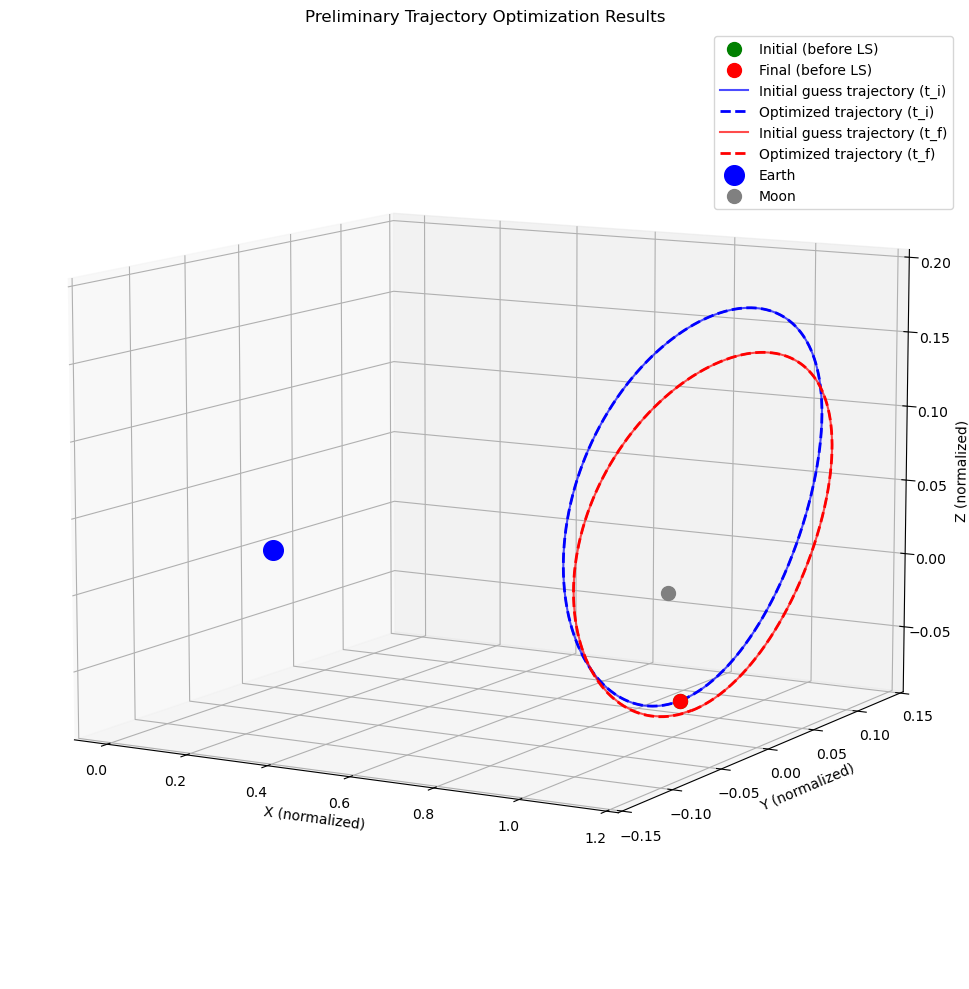

In [7]:
# Perform Trajectory Optimization

print("Optimizing boundary conditions and transfer times...")

# Optimize final time using target final state
print("  Optimizing final time...")
res_time = scipy.optimize.minimize(
    obj_time, [t_f], 
    args=(r_f, v_f), 
    method='SLSQP', 
    tol=1e-6
)
t_f_opt = res_time['x'][0]

# Optimize initial state to match periodic orbit constraint
print("  Optimizing initial state...")
res_x_i = scipy.optimize.minimize(
    obj_ls, np.concatenate((r_i, v_i)), 
    args=(t_i,), 
    method='SLSQP', 
    tol=1e-6
)
x_i = res_x_i['x']

# Optimize final state to match periodic orbit constraint  
print("  Optimizing final state...")
res_x_f = scipy.optimize.minimize(
    obj_ls, np.concatenate((r_f, v_f)), 
    args=(t_f,), 
    method='SLSQP', 
    tol=1e-6
)
x_f = res_x_f['x']

# Integrate trajectories for initial guess and optimized states
print("  Integrating trajectories...")
sol_1 = scipy.integrate.solve_ivp(
    ode, (0, t_i), np.concatenate([r_i, v_i]),
    t_eval=np.linspace(0, t_i, 1000), rtol=1e-10
)
sol_2 = scipy.integrate.solve_ivp(
    ode, (0, t_i), x_i,
    t_eval=np.linspace(0, t_i, 1000), rtol=1e-10
)

sol_1_f = scipy.integrate.solve_ivp(
    ode, (0, t_f), np.concatenate([r_f, v_f]),
    t_eval=np.linspace(0, t_f, 1000), rtol=1e-10
)
sol_2_f = scipy.integrate.solve_ivp(
    ode, (0, t_f), x_f,
    t_eval=np.linspace(0, t_f, 1000), rtol=1e-10
)

print(f"Optimization completed!")
print(f"  Optimized final time: {t_f_opt:.6f}")
print(f"  Initial state optimization success: {res_x_i.success}")
print(f"  Final state optimization success: {res_x_f.success}")

# Plot preliminary trajectories
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sol_1.y[0, 0], sol_1.y[1, 0], sol_1.y[2, 0], 
           color='green', s=100, label='Initial (before LS)')
ax.scatter(sol_1.y[0, -1], sol_1.y[1, -1], sol_1.y[2, -1], 
           color='red', s=100, label='Final (before LS)')

ax.plot(sol_1.y[0, :], sol_1.y[1, :], sol_1.y[2, :], 
        'b-', label='Initial guess trajectory (t_i)', alpha=0.7)
ax.plot(sol_2.y[0, :], sol_2.y[1, :], sol_2.y[2, :], 
        'b--', label='Optimized trajectory (t_i)', linewidth=2)

ax.plot(sol_1_f.y[0, :], sol_1_f.y[1, :], sol_1_f.y[2, :], 
        'r-', label='Initial guess trajectory (t_f)', alpha=0.7)
ax.plot(sol_2_f.y[0, :], sol_2_f.y[1, :], sol_2_f.y[2, :], 
        'r--', label='Optimized trajectory (t_f)', linewidth=2)

# Plot Earth and Moon
ax.scatter([0], [0], [0], c='blue', s=200, label='Earth')
ax.scatter([1-mu_val], [0], [0], c='gray', s=100, label='Moon')

ax.set_xlabel('X (normalized)')
ax.set_ylabel('Y (normalized)')
ax.set_zlabel('Z (normalized)')
ax.set_title('Preliminary Trajectory Optimization Results')
ax.view_init(elev=10, azim=300)
ax.legend()
plt.tight_layout()
plt.show()

Generating initial trajectory guess for SCVX...
  Computing periodic orbits...
    Iteration 1/20
    Iteration 2/20
    Iteration 3/20
    Iteration 4/20
    Iteration 5/20
    Iteration 6/20
    Iteration 7/20
    Iteration 8/20
    Iteration 9/20
    Iteration 10/20
    Iteration 11/20
    Iteration 12/20
    Iteration 13/20
    Iteration 14/20
    Iteration 15/20
    Iteration 16/20
    Iteration 17/20
    Iteration 18/20
    Iteration 19/20
    Iteration 20/20
  Generated 20 periodic orbit segments
Initial trajectory guess created:
  Discretization points: 400
  State dimension: 7 (6 dynamics + 1 mass)
  Mass range: 1000 kg → 500 kg


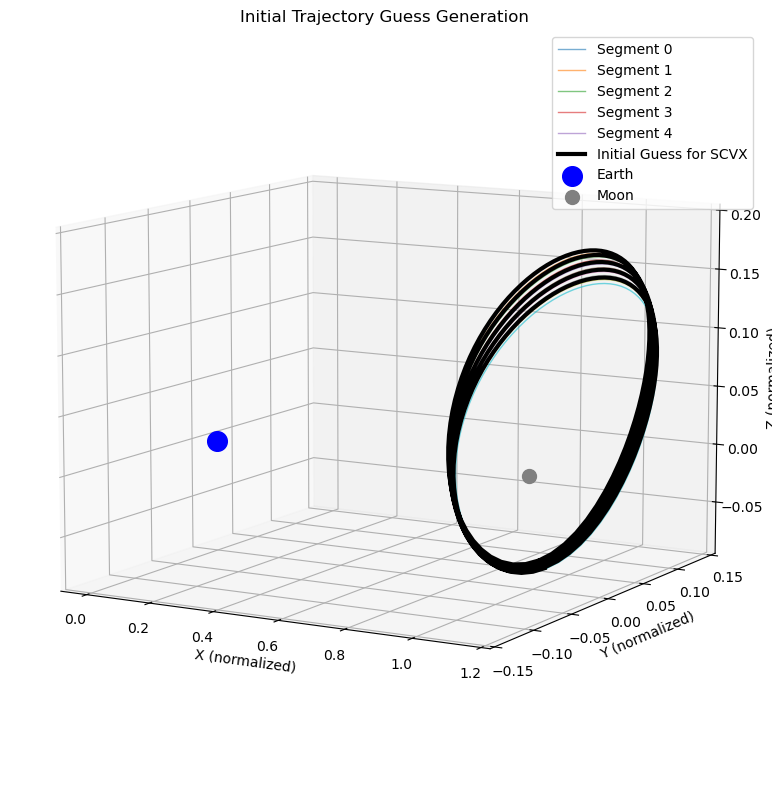

In [8]:
# Generate Initial Trajectory Guess

print("Generating initial trajectory guess for SCVX...")

# Create interpolation points between optimized initial and final states
N_interp = 20
x_linspace = np.linspace(x_i, x_f, N_interp)
t_linspace = np.linspace(t_i, t_f, N_interp)

# Jacobi constant placeholder (for energy-like conservation)
def jacobi_constant(state):
    """
    Placeholder for Jacobi constant computation.
    In the CR3BP, this is a conserved quantity related to energy.
    """
    return 0  # Simplified for this example

# Storage for trajectory data
ts = []
jacobi_constants = []
xs = []
trajectories = []

# VT optimization functions for periodic orbits
def obj_vt(vt, r):
    """
    Velocity-time optimization for periodic orbits.
    
    Args:
        vt: [vy, t] - y-velocity and time parameters
        r: Position vector
    
    Returns:
        Periodic orbit error
    """
    vy, t_val = vt[0], vt[1]
    x = np.concatenate([r, np.array([0.0, vy, 0.0])])
    sol = scipy.integrate.solve_ivp(
        ode, (0, t_val), x,
        t_eval=np.linspace(0, t_val, 1000), 
        rtol=1e-10
    )
    err = sol.y[:, -1] - x
    return np.dot(err, err)

def find_vy_t(r, vy0, t0):
    """
    Find optimal y-velocity and time for periodic orbit.
    
    Args:
        r: Position vector
        vy0: Initial guess for y-velocity
        t0: Initial guess for time
    
    Returns:
        Optimized (vy, t) pair
    """
    vt0 = np.array([vy0, t0])
    opt_sol = scipy.optimize.minimize(
        obj_vt, vt0, args=(r,), 
        method='SLSQP', tol=1e-6
    )
    return opt_sol['x']

# Generate periodic orbit trajectories
print("  Computing periodic orbits...")
for i in range(x_linspace.shape[0]):
    print(f"    Iteration {i+1}/{N_interp}")
    r = x_linspace[i, :3]
    
    # Find optimal velocity and time for this position
    vy, t_val = find_vy_t(r, x_linspace[i, 4], t_linspace[i])
    
    # Integrate trajectory
    traj = scipy.integrate.solve_ivp(
        ode, (0, t_val), 
        np.concatenate([r, np.array([0.0, vy, 0.0])]),
        t_eval=np.linspace(0, t_val, 80), 
        rtol=1e-10
    )
    
    trajectories.append(traj.y)
    ts.append(t_val)
    jacobi_constants.append(jacobi_constant(np.concatenate([r, np.array([0.0, vy, 0.0])])))
    xs.append(np.concatenate([r, np.array([0.0, vy, 0.0])]))

xs = np.array(xs)
print(f"  Generated {len(trajectories)} periodic orbit segments")

# Create continuous initial trajectory for SCVX
N = 400  # Number of discretization points for SCVX
np_trajectories = np.stack(trajectories).transpose((0, 2, 1))

# Initialize trajectory matrix (6 position/velocity + 1 mass dimension)
init_traj = np.zeros((N, 7))

# Fill position and velocity from periodic orbit data
for i in range(5):
    start_idx = i * 80
    end_idx = (i + 1) * 80
    traj_idx = i * 19 // 5  # Map to available trajectory segments
    if traj_idx < len(np_trajectories):
        init_traj[start_idx:end_idx, :6] = np_trajectories[traj_idx, :, :]

# Add mass dimension (logarithmic mass decrease)
init_mass = np.log(np.linspace(m0, m0/2, N))
init_traj[:, 6] = init_mass

print(f"Initial trajectory guess created:")
print(f"  Discretization points: {N}")
print(f"  State dimension: {init_traj.shape[1]} (6 dynamics + 1 mass)")
print(f"  Mass range: {m0:.0f} kg → {m0/2:.0f} kg")

# Plot initial trajectory guess
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot periodic orbit segments
for i, traj in enumerate(trajectories[::2]):  # Plot every 2nd trajectory
    ax.plot(traj[0, :], traj[1, :], traj[2, :], 
            alpha=0.6, linewidth=1, label=f'Segment {i}' if i < 5 else None)

# Plot interpolated initial guess
ax.plot(init_traj[:, 0], init_traj[:, 1], init_traj[:, 2], 
        'k-', linewidth=3, label='Initial Guess for SCVX')

# Plot celestial bodies
ax.scatter([0], [0], [0], c='blue', s=200, label='Earth')
ax.scatter([1-mu_val], [0], [0], c='gray', s=100, label='Moon')

ax.set_xlabel('X (normalized)')
ax.set_ylabel('Y (normalized)')
ax.set_zlabel('Z (normalized)')
ax.set_title('Initial Trajectory Guess Generation')
ax.view_init(elev=10, azim=300)
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
# Set Up SCVX Optimization Program

print("Initializing SCVX optimization program...")

# Boundary conditions are 6-dimensional (position and velocity only)
# Mass is handled separately through z variable (log mass)
print(f"Boundary conditions (6D state):")
print(f"  Initial: position {x_i[:3]}, velocity {x_i[3:6]}")
print(f"  Final:   position {x_f[:3]}, velocity {x_f[3:6]}")
print(f"  Log mass: initial {np.log(m0):.3f}, final {np.log(m0/2):.3f}")

# Create initial trajectory matrix (6 position/velocity dimensions only)
# Mass is handled through z variable in SCVX
init_traj_6d = init_traj[:, :6]  # Remove mass dimension from trajectory

print(f"Initial trajectory for SCVX:")
print(f"  Discretization points: {N}")
print(f"  State dimension: {init_traj_6d.shape[1]} (6D: position + velocity)")
print(f"  Mass handled separately via z variable")

# Create CVX program with nonlinearity index and mesh refinement
program = CVXProgram(
    dynamics=cr3bp_dynamics,
    N=N,
    t_f=(t_f + t_i) * 2.5,  # Total mission time
    T_max=T_max,
    c=c_val,
    x_i=x_i,                # 6-dimensional initial state
    x_f=x_f,                # 6-dimensional final state
    z_0=np.log(m0),         # Initial log mass
    init_traj=init_traj_6d, # 6-dimensional trajectory
    init_z_map=init_mass,   # Log mass profile
    trust_region_mode='nonlinear_idx',  # Enable nonlinearity index
    mesh_refinement_enabled=True,       # Enable adaptive mesh refinement
    # Trust region parameters
    rho0=0.04, rho1=0.2, rho2=0.7,    # Trust region update thresholds
    alpha=1.5, beta=1.5,               # Trust region scaling factors
    # Optimization parameters
    tolerance=1e- ,                    # Convergence tolerance
    C=5.0,                            # Penalty parameter
    nonlinear_idx_multiplier=0.1,     # Nonlinearity index weight
    # Constraint parameters
    mul_min_clamp=0.5,                # Min multiplier clamp
    mul_max_clamp=20.0                # Max multiplier clamp
)

print(f"SCVX program initialized:")
print(f"  Discretization points: {N}")
print(f"  Mission time: {(t_f + t_i) * 2.5:.3f} (normalized)")
print(f"  Trust region mode: nonlinear_idx")
print(f"  Mesh refinement: enabled")
print(f"  Max thrust: {T_max:.6e}")
print(f"  Characteristic velocity: {c_val:.3f}")

# Run initial optimization
print("\nRunning initial optimization...")
try:
    result = program.optimize()
    print(f"Initial optimization completed. Converged: {result}")
except Exception as e:
    print(f"Initial optimization failed: {e}")
    result = False

Initializing SCVX optimization program...
Boundary conditions (6D state):
  Initial: position [ 1.01762231e+00  4.30043969e-09 -6.99293778e-02], velocity [ 1.22829391e-09  4.86581214e-01 -1.25121391e-09]
  Final:   position [ 1.04529484e+00  1.50957305e-05 -7.55340220e-02], velocity [-5.67024085e-05  3.87703898e-01 -1.10071700e-04]
  Log mass: initial 6.908, final 6.215
Initial trajectory for SCVX:
  Discretization points: 400
  State dimension: 6 (6D: position + velocity)
  Mass handled separately via z variable
SCVX program initialized:
  Discretization points: 400
  Mission time: 15.118 (normalized)
  Trust region mode: nonlinear_idx
  Mesh refinement: enabled
  Max thrust: 3.671471e+00
  Characteristic velocity: 28.752

Running initial optimization...


/home/potato/anaconda3/envs/aero/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/potato/anaconda3/envs/aero/lib/python3.11/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


Initial optimization completed. Converged: (False, np.float64(0.05518064926244815), np.float64(0.9064650499887774))


Starting iterative SCVX optimization with detailed tracking...
\n--- Iteration 1 ---
Final mass: 998.9819 kg, Propellant used: 1.0181 kg
Linear cost: 4.371779e-02
Nonlinear cost: 9.658140e-01
Trust region value: 6.666667e-02
Convergence metrics: (np.float64(0.04371779192192784), np.float64(0.9658139582781894))


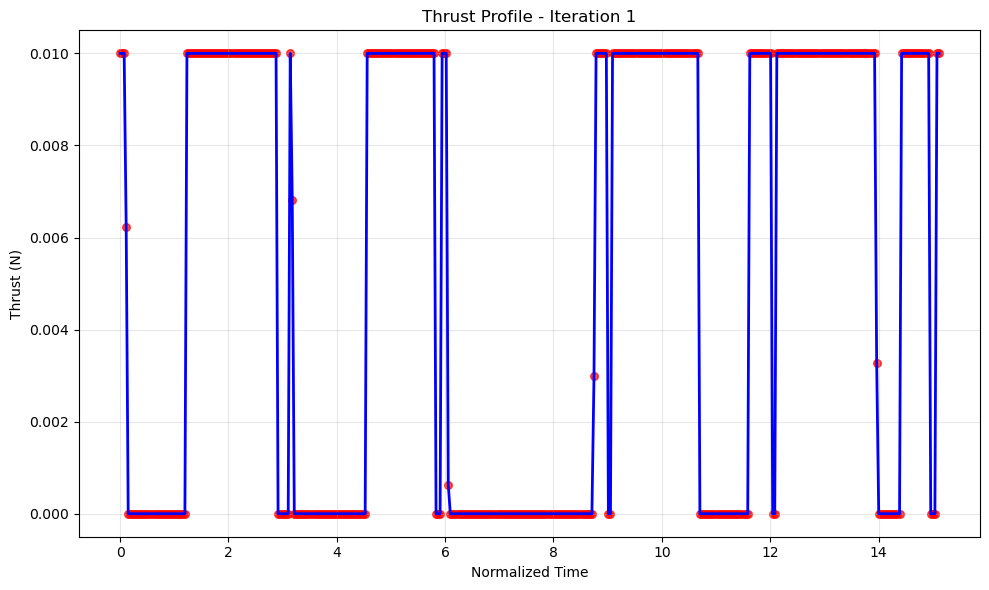

Iteration 1 completed. Converged: False
\n--- Iteration 2 ---
Final mass: 998.7790 kg, Propellant used: 1.2210 kg
Linear cost: 5.855307e-02
Nonlinear cost: 5.796830e-01
Trust region value: 6.666667e-02
Convergence metrics: (np.float64(0.05855306717652164), np.float64(0.579683006854921))
Iteration 2 completed. Converged: False
\n--- Iteration 3 ---
Final mass: 998.8914 kg, Propellant used: 1.1086 kg
Linear cost: 5.175468e-02
Nonlinear cost: 4.005350e-01
Trust region value: 6.666667e-02
Convergence metrics: (np.float64(0.051754675647654236), np.float64(0.4005349883692457))
Iteration 3 completed. Converged: False
\n--- Iteration 4 ---
Final mass: 998.9502 kg, Propellant used: 1.0498 kg
Linear cost: 5.488690e-02
Nonlinear cost: 2.795680e-01
Trust region value: 6.666667e-02
Convergence metrics: (np.float64(0.05488690175407841), np.float64(0.27956795138445345))
Iteration 4 completed. Converged: False
\n--- Iteration 5 ---
Final mass: 998.9622 kg, Propellant used: 1.0378 kg
Linear cost: 5.971

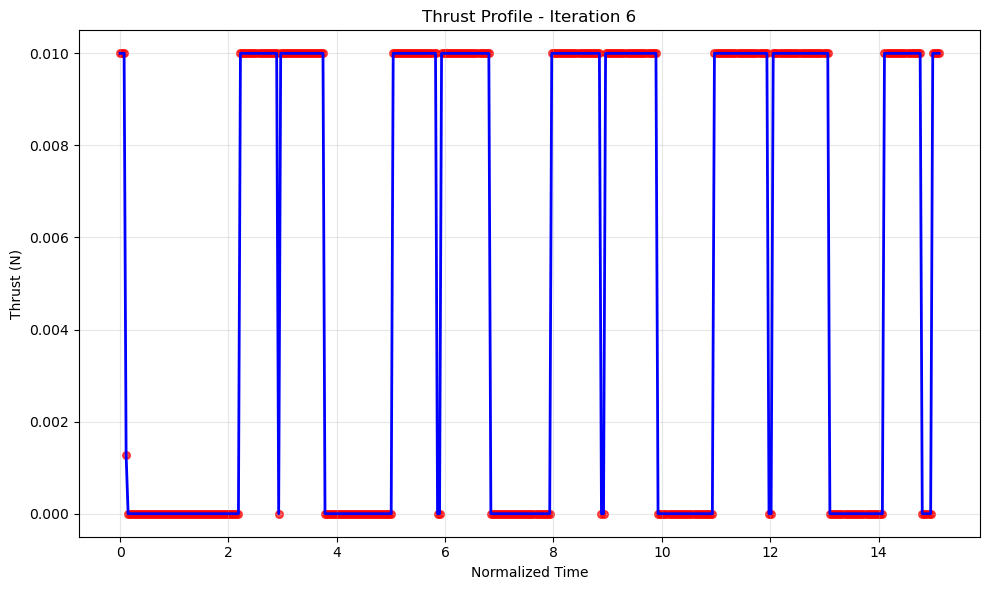

Iteration 6 completed. Converged: False
\n--- Iteration 7 ---
Final mass: 998.9656 kg, Propellant used: 1.0344 kg
Linear cost: 6.011115e-02
Nonlinear cost: 1.760772e-01
Trust region value: 4.444444e-02
Convergence metrics: (np.float64(0.06011115485765146), np.float64(0.17607718912918147))
Iteration 7 completed. Converged: False
\n--- Iteration 8 ---
Final mass: 998.9622 kg, Propellant used: 1.0378 kg
Linear cost: 6.004379e-02
Nonlinear cost: 1.958930e-01
Trust region value: 2.962963e-02
Convergence metrics: (np.float64(0.06004378532367734), np.float64(0.19589301170435347))
Iteration 8 completed. Converged: False
\n--- Iteration 9 ---
Final mass: 998.9638 kg, Propellant used: 1.0362 kg
Linear cost: 6.024675e-02
Nonlinear cost: 1.245029e-01
Trust region value: 2.962963e-02
Convergence metrics: (np.float64(0.060246746636892834), np.float64(0.12450288238559422))
Iteration 9 completed. Converged: False
\n--- Iteration 10 ---
Final mass: 998.9625 kg, Propellant used: 1.0375 kg
Linear cost: 6

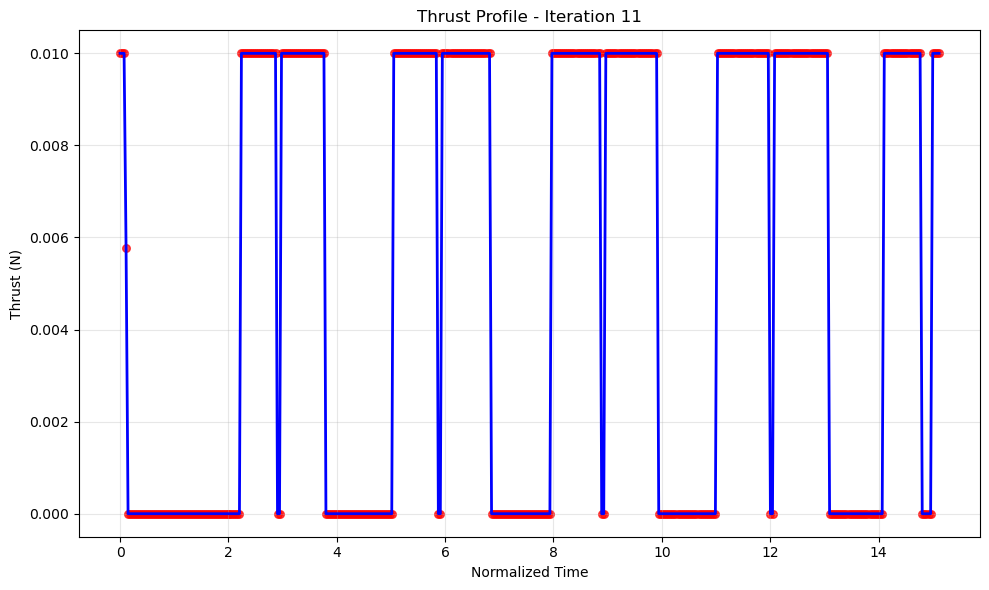

Iteration 11 completed. Converged: False
\n--- Iteration 12 ---
Final mass: 998.9558 kg, Propellant used: 1.0442 kg
Linear cost: 6.041556e-02
Nonlinear cost: 1.203266e-01
Trust region value: 1.975309e-02
Convergence metrics: (np.float64(0.060415555054666815), np.float64(0.12032660560345432))
Iteration 12 completed. Converged: False
\n--- Iteration 13 ---
Final mass: 998.9560 kg, Propellant used: 1.0440 kg
Linear cost: 6.048304e-02
Nonlinear cost: 9.003495e-02
Trust region value: 1.975309e-02
Convergence metrics: (np.float64(0.060483037296006334), np.float64(0.0900349533269866))
Iteration 13 completed. Converged: False
\n--- Iteration 14 ---
Final mass: 998.9564 kg, Propellant used: 1.0436 kg
Linear cost: 6.067032e-02
Nonlinear cost: 8.828104e-02
Trust region value: 1.316872e-02
Convergence metrics: (np.float64(0.0606703174702888), np.float64(0.08828103681309099))
Iteration 14 completed. Converged: False
\n--- Iteration 15 ---
Final mass: 998.9499 kg, Propellant used: 1.0501 kg
Linear c

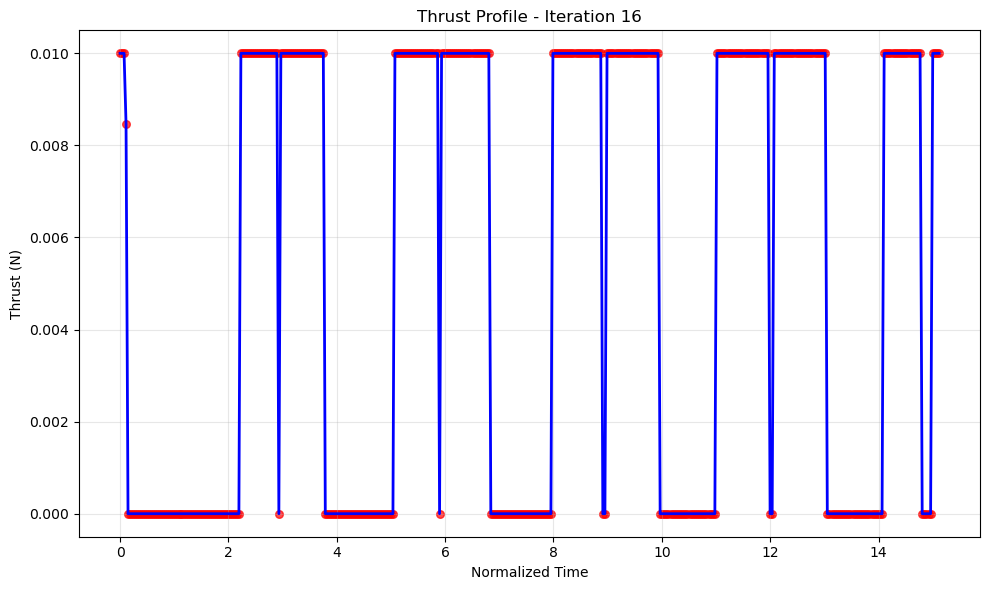

Iteration 16 completed. Converged: False
\n--- Iteration 17 ---
Final mass: 998.9689 kg, Propellant used: 1.0311 kg
Linear cost: 6.107578e-02
Nonlinear cost: 7.031325e-02
Trust region value: 5.852766e-03
Convergence metrics: (np.float64(0.06107577646603384), np.float64(0.07031324802713429))
Iteration 17 completed. Converged: False
\n--- Iteration 18 ---
Final mass: 998.9585 kg, Propellant used: 1.0415 kg
Linear cost: 6.076846e-02
Nonlinear cost: 6.434151e-02
Trust region value: 5.852766e-03
Convergence metrics: (np.float64(0.060768455583368165), np.float64(0.06434150801846994))
Iteration 18 completed. Converged: False
\n--- Iteration 19 ---
Final mass: 998.9599 kg, Propellant used: 1.0401 kg
Linear cost: 6.100658e-02
Nonlinear cost: 6.571629e-02
Trust region value: 3.901844e-03
Convergence metrics: (np.float64(0.06100657623467032), np.float64(0.06571629078173843))
Iteration 19 completed. Converged: False
\n--- Iteration 20 ---
Final mass: 998.9627 kg, Propellant used: 1.0373 kg
Linear 

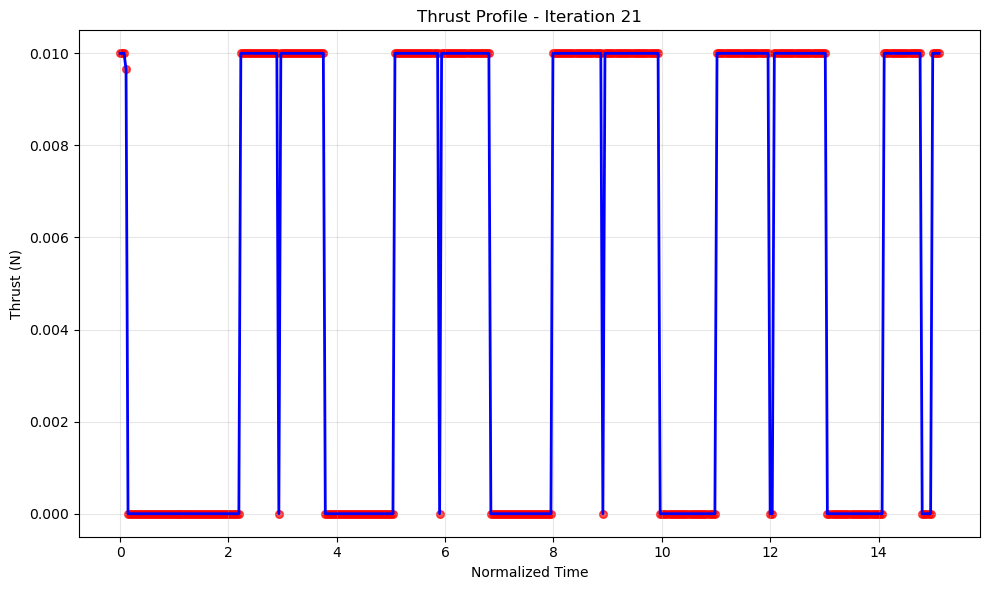

Iteration 21 completed. Converged: False
\n--- Iteration 22 ---
Final mass: 998.9625 kg, Propellant used: 1.0375 kg
Linear cost: 6.090807e-02
Nonlinear cost: 6.154449e-02
Trust region value: 5.852766e-03
Convergence metrics: (np.float64(0.06090806518631923), np.float64(0.06154449412791474))
Iteration 22 completed. Converged: False
\n--- Iteration 23 ---
Final mass: 998.9622 kg, Propellant used: 1.0378 kg
Linear cost: 6.091276e-02
Nonlinear cost: 6.163404e-02
Trust region value: 3.901844e-03
Convergence metrics: (np.float64(0.060912761005217725), np.float64(0.061634043281607175))
Iteration 23 completed. Converged: False
\n--- Iteration 24 ---
Final mass: 998.9623 kg, Propellant used: 1.0377 kg
Linear cost: 6.091754e-02
Nonlinear cost: 6.144517e-02
Trust region value: 3.901844e-03
Convergence metrics: (np.float64(0.060917540545559916), np.float64(0.06144516523926291))
Iteration 24 completed. Converged: False
\n--- Iteration 25 ---
Final mass: 998.9619 kg, Propellant used: 1.0381 kg
Linea

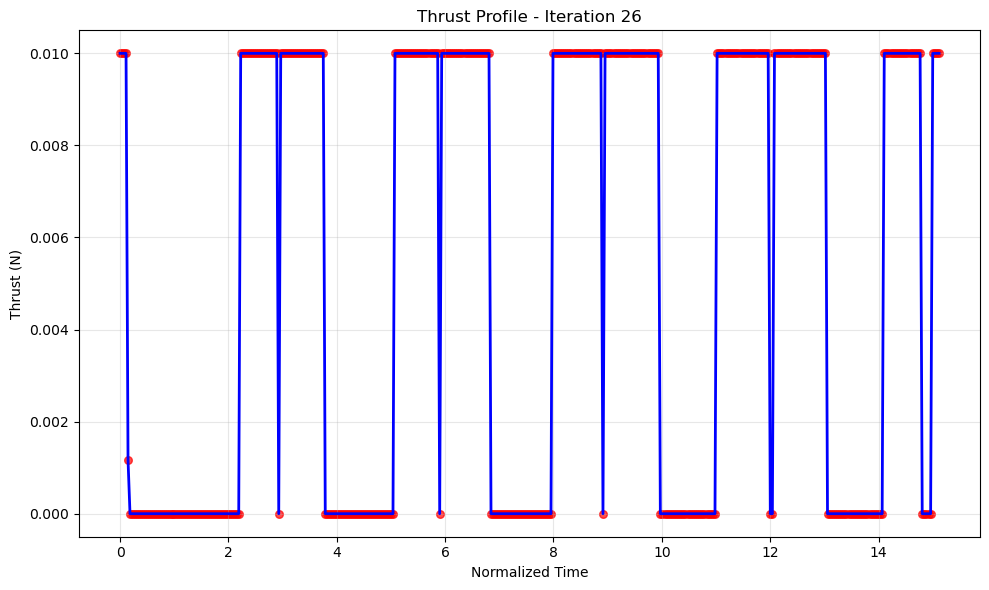

Iteration 26 completed. Converged: False
\n--- Iteration 27 ---
Final mass: 998.9616 kg, Propellant used: 1.0384 kg
Linear cost: 6.093588e-02
Nonlinear cost: 6.117975e-02
Trust region value: 2.601229e-03
Convergence metrics: (np.float64(0.06093588417148084), np.float64(0.061179747374622284))
Iteration 27 completed. Converged: False
\n--- Iteration 28 ---
Final mass: 998.9613 kg, Propellant used: 1.0387 kg
Linear cost: 6.094202e-02
Nonlinear cost: 6.112722e-02
Trust region value: 2.601229e-03
Convergence metrics: (np.float64(0.0609420220969227), np.float64(0.061127219207713315))
Iteration 28 completed. Converged: False
\n--- Iteration 29 ---
Final mass: 998.9610 kg, Propellant used: 1.0390 kg
Linear cost: 6.094785e-02
Nonlinear cost: 6.112603e-02
Trust region value: 1.734153e-03
Convergence metrics: (np.float64(0.060947849873180866), np.float64(0.06112602550956893))
Iteration 29 completed. Converged: False
\n--- Iteration 30 ---
Final mass: 998.9611 kg, Propellant used: 1.0389 kg
Linear

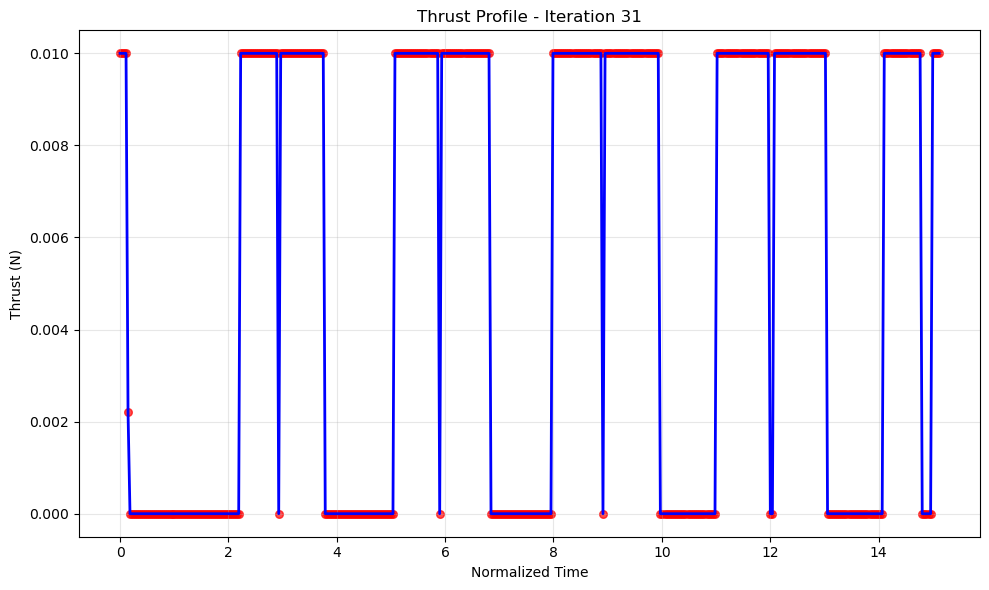

Iteration 31 completed. Converged: False
\n--- Iteration 32 ---
Final mass: 998.9607 kg, Propellant used: 1.0393 kg
Linear cost: 6.096007e-02
Nonlinear cost: 6.106745e-02
Trust region value: 1.156102e-03
Convergence metrics: (np.float64(0.060960069921042644), np.float64(0.06106744573097421))
Iteration 32 completed. Converged: False
\n--- Iteration 33 ---
Final mass: 998.9607 kg, Propellant used: 1.0393 kg
Linear cost: 6.096133e-02
Nonlinear cost: 6.105009e-02
Trust region value: 7.707347e-04
Convergence metrics: (np.float64(0.06096133175321585), np.float64(0.061050086959569774))
Iteration 33 completed. Converged: False
\n--- Iteration 34 ---
Final mass: 998.9606 kg, Propellant used: 1.0394 kg
Linear cost: 6.096587e-02
Nonlinear cost: 6.102245e-02
Trust region value: 7.707347e-04
Convergence metrics: (np.float64(0.06096586687632594), np.float64(0.06102245171126229))
Iteration 34 completed. Converged: False
\n--- Iteration 35 ---
Final mass: 998.9604 kg, Propellant used: 1.0396 kg
Linear

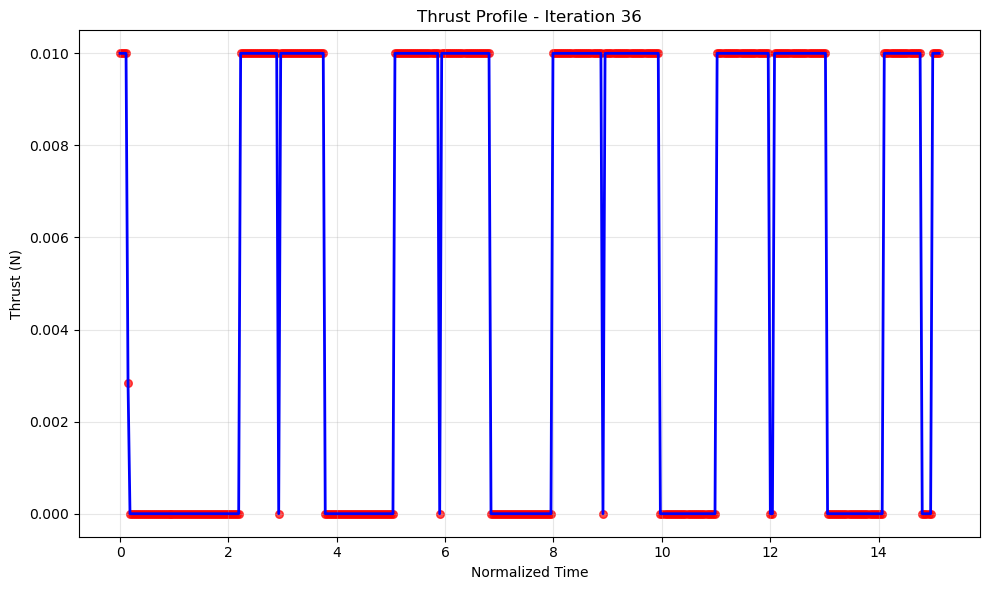

Iteration 36 completed. Converged: False
\n--- Iteration 37 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear cost: 6.097042e-02
Nonlinear cost: 6.101806e-02
Trust region value: 2.283658e-04
Convergence metrics: (np.float64(0.06097042098739296), np.float64(0.06101805888839715))
Iteration 37 completed. Converged: False
\n--- Iteration 38 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear cost: 6.097067e-02
Nonlinear cost: 6.101775e-02
Trust region value: 1.522439e-04
Convergence metrics: (np.float64(0.06097066790153648), np.float64(0.061017748231829524))
Iteration 38 completed. Converged: False
\n--- Iteration 39 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear cost: 6.097083e-02
Nonlinear cost: 6.101756e-02
Trust region value: 1.014959e-04
Convergence metrics: (np.float64(0.06097083236797489), np.float64(0.06101756201105767))
Iteration 39 completed. Converged: False
\n--- Iteration 40 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear 

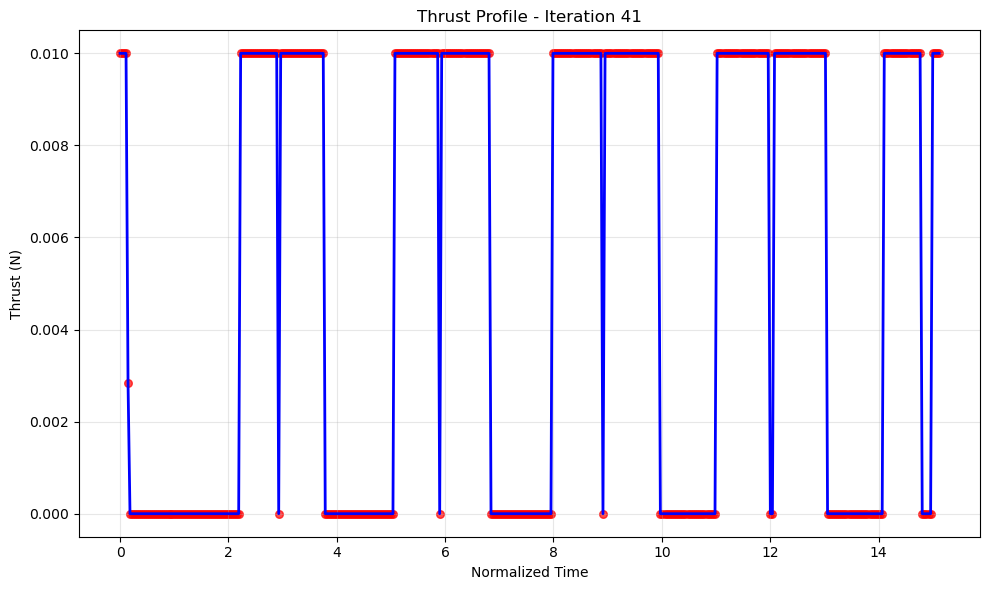

Iteration 41 completed. Converged: False
\n--- Iteration 42 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear cost: 6.097106e-02
Nonlinear cost: 6.101742e-02
Trust region value: 3.007287e-05
Convergence metrics: (np.float64(0.06097106395256816), np.float64(0.061017423879277555))
Iteration 42 completed. Converged: False
\n--- Iteration 43 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear cost: 6.097110e-02
Nonlinear cost: 6.101745e-02
Trust region value: 2.004858e-05
Convergence metrics: (np.float64(0.0609710965009041), np.float64(0.06101744860476702))
Iteration 43 completed. Converged: False
\n--- Iteration 44 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear cost: 6.097112e-02
Nonlinear cost: 6.101747e-02
Trust region value: 1.336572e-05
Convergence metrics: (np.float64(0.06097111812603845), np.float64(0.061017473415241046))
Iteration 44 completed. Converged: False
\n--- Iteration 45 ---
Final mass: 998.9605 kg, Propellant used: 1.0395 kg
Linear 

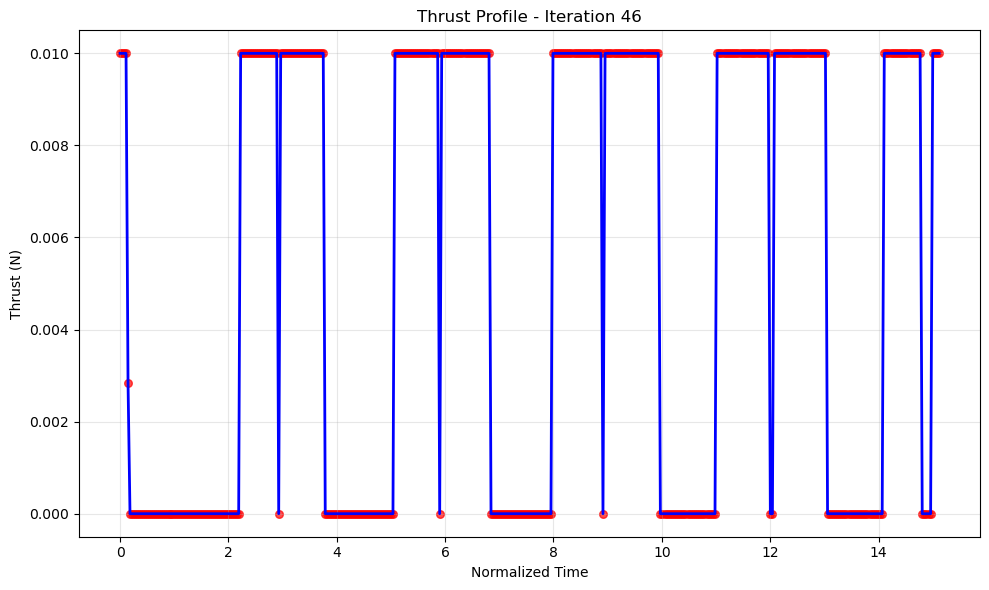

Iteration 46 completed. Converged: False
\n--- Iteration 47 ---
Final mass: 998.9604 kg, Propellant used: 1.0396 kg
Linear cost: 6.097380e-02
Nonlinear cost: 6.100633e-02
Trust region value: 3.960213e-06
Convergence metrics: (np.float64(0.06097379996672105), np.float64(0.061006334159290986))
Iteration 47 completed. Converged: False
\n--- Iteration 48 ---
Final mass: 998.9603 kg, Propellant used: 1.0397 kg
Linear cost: 6.097606e-02
Nonlinear cost: 6.101722e-02
Trust region value: 2.640142e-06
Convergence metrics: (np.float64(0.06097606024710492), np.float64(0.06101722028224563))
Iteration 48 completed. Converged: False
\n--- Iteration 49 ---
Final mass: 998.9603 kg, Propellant used: 1.0397 kg
Linear cost: 6.097610e-02
Nonlinear cost: 6.103192e-02
Trust region value: 1.760095e-06
Convergence metrics: (np.float64(0.06097609570031814), np.float64(0.06103191535347431))
Iteration 49 completed. Converged: False
\n--- Iteration 50 ---
Final mass: 998.9603 kg, Propellant used: 1.0397 kg
Linear 

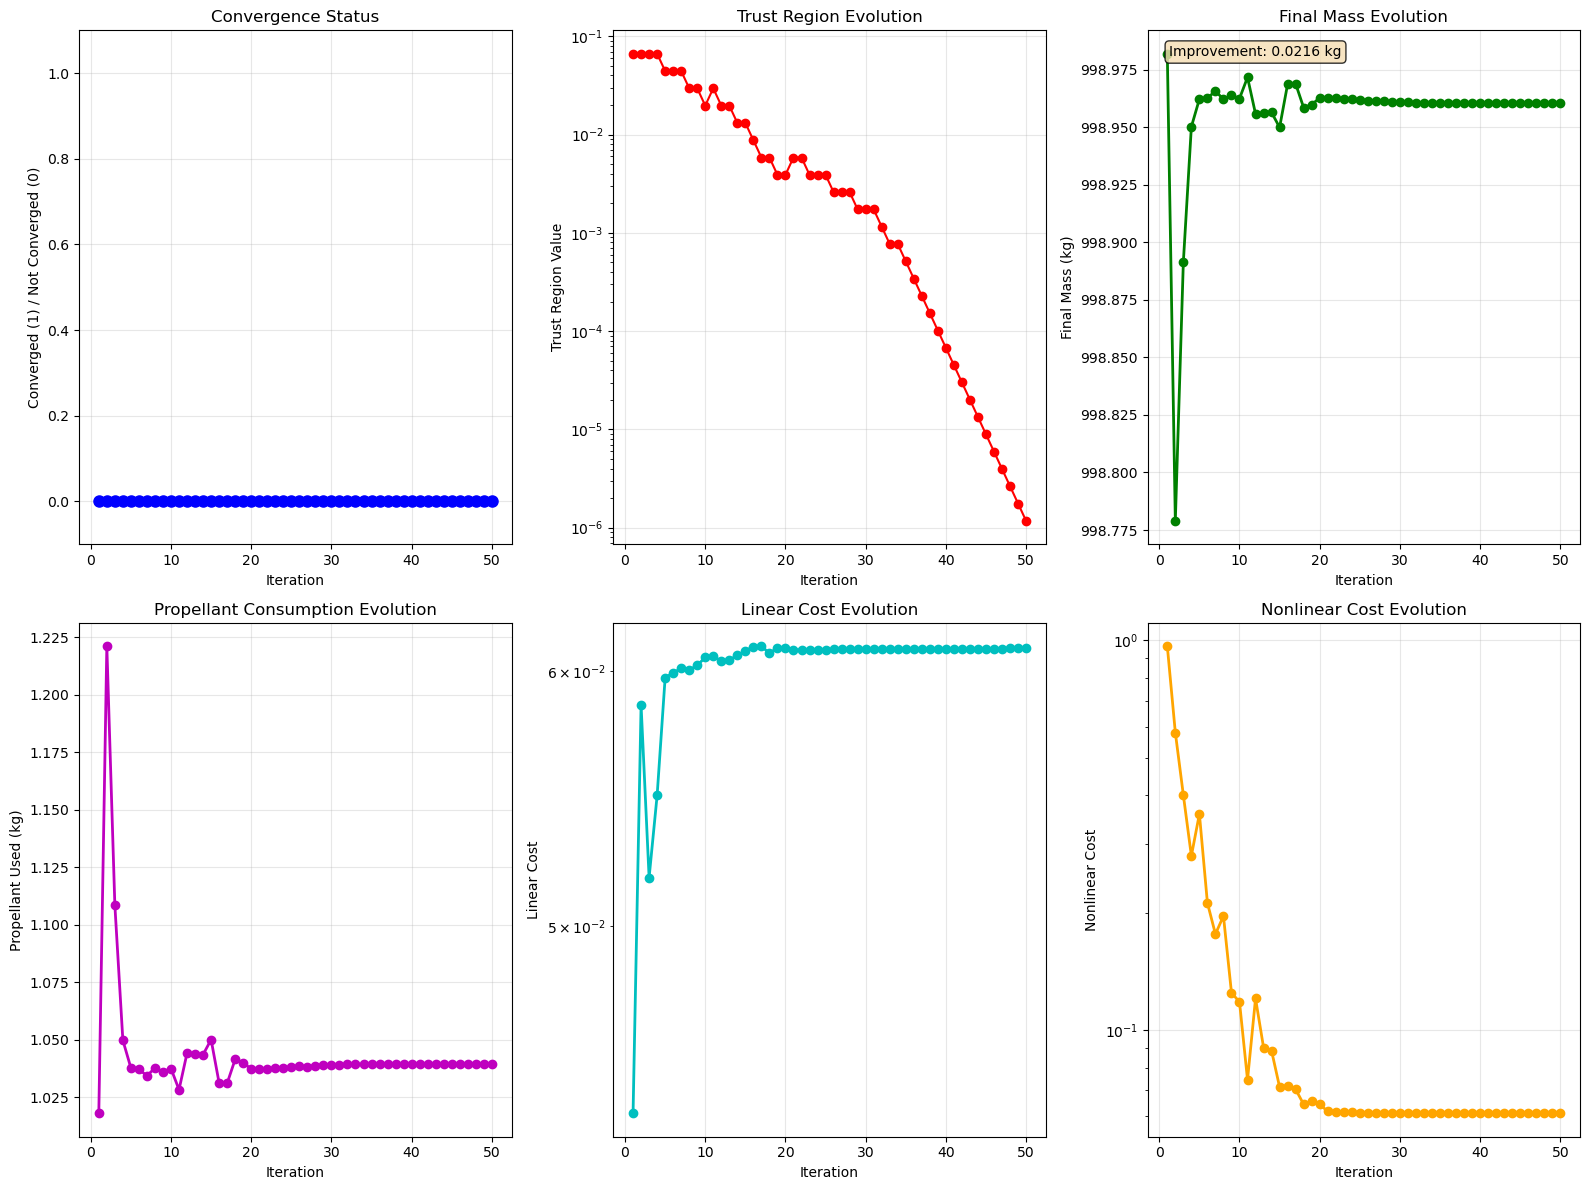

\n--- SCVX Effectiveness Analysis ---


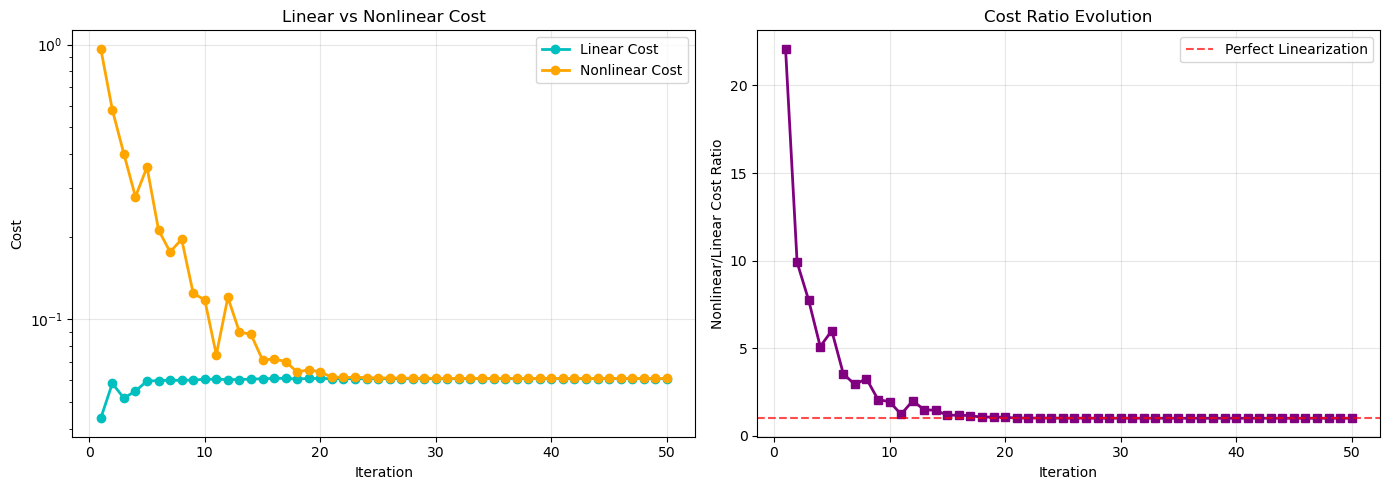

  Initial cost ratio: 22.092011
  Final cost ratio: 1.000953
  Ratio improvement: 21.091058
  Average cost ratio: 2.149932
  Mass optimization improvement: 0.0022%
  Linear cost reduction: -39.4766%
  Nonlinear cost reduction: 93.6805%


In [10]:
# Run Iterative Optimization Loop with Detailed Tracking

print("Starting iterative SCVX optimization with detailed tracking...")

converged = False
iteration = 0
max_iterations = 50

# Track optimization progress
convergence_history = []
trust_region_history = []
final_mass_history = []
linear_cost_history = []
nonlinear_cost_history = []
propellant_used_history = []

while not converged and iteration < max_iterations:
    print(f"\\n--- Iteration {iteration + 1} ---")
    
    try:
        # Run optimization step
        result = program.optimize()
        
        # Extract convergence status (handle both boolean and tuple returns)
        if isinstance(result, tuple):
            converged = bool(result[0])  # First element is convergence status
            convergence_metrics = result[1:] if len(result) > 1 else []
        else:
            converged = bool(result)
            convergence_metrics = []
        
        # Record convergence status
        convergence_history.append(converged)
        
        # Track final mass evolution
        if hasattr(program, 'z') and program.z.value is not None:
            final_mass = np.exp(program.z.value[-1])
            final_mass_history.append(final_mass)
            propellant_used = m0 - final_mass
            propellant_used_history.append(propellant_used)
            print(f"Final mass: {final_mass:.4f} kg, Propellant used: {propellant_used:.4f} kg")
        
        # Track linear and nonlinear costs
        if hasattr(program, 'linear_cost') and program.linear_cost is not None:
            linear_cost_history.append(float(program.linear_cost))
            print(f"Linear cost: {program.linear_cost:.6e}")
        
        if hasattr(program, 'nonlinear_cost') and program.nonlinear_cost is not None:
            nonlinear_cost_history.append(float(program.nonlinear_cost))
            print(f"Nonlinear cost: {program.nonlinear_cost:.6e}")
        
        # Print trust region information
        if hasattr(program, 'trust_region'):
            trust_region_val = program.trust_region[0] if len(program.trust_region) > 0 else 0
            trust_region_history.append(trust_region_val)
            print(f"Trust region value: {trust_region_val:.6e}")
        
        # Print convergence metrics if available
        if convergence_metrics:
            print(f"Convergence metrics: {convergence_metrics}")
        
        # Plot thrust profile for this iteration
        if hasattr(program, 's') and program.s.value is not None:
            # Calculate time steps
            days = np.concatenate(([0], np.cumsum(program.s.value))) / (program.N - 1)
            
            # Calculate thrust values if attributes exist
            if hasattr(program, 'tau_len') and hasattr(program, 'z_p'):
                thrust_values = (program.tau_len.value * np.exp(program.z_p) / (TU**2) * LUm / 
                               np.concatenate([program.s.value, [program.s.value[-1]]]))
                
                # Plot every 5th iteration or if converged
                if iteration % 5 == 0 or converged:
                    plt.figure(figsize=(10, 6))
                    plt.plot(days, thrust_values, 'b-', linewidth=2)
                    plt.scatter(days, thrust_values, c='red', s=30, alpha=0.7)
                    plt.xlabel('Normalized Time')
                    plt.ylabel('Thrust (N)')
                    plt.title(f'Thrust Profile - Iteration {iteration + 1}')
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
        
        print(f"Iteration {iteration + 1} completed. Converged: {converged}")
        
    except Exception as e:
        print(f"Iteration {iteration + 1} failed: {e}")
        break
    
    iteration += 1

# Print final results
print(f"\\n=== Optimization Complete ===")
print(f"Total iterations: {iteration}")
print(f"Final convergence status: {converged}")
print(f"Maximum iterations reached: {iteration >= max_iterations}")

if len(trust_region_history) > 0:
    print(f"Final trust region value: {trust_region_history[-1]:.6e}")

if len(final_mass_history) > 0:
    print(f"Initial final mass: {final_mass_history[0]:.4f} kg")
    print(f"Final final mass: {final_mass_history[-1]:.4f} kg")
    print(f"Mass improvement: {final_mass_history[0] - final_mass_history[-1]:.4f} kg")

# Create comprehensive convergence analysis plot
fig = plt.figure(figsize=(16, 12))

# 1. Convergence Status
ax1 = plt.subplot(2, 3, 1)
if len(convergence_history) > 1:
    plt.plot(range(1, len(convergence_history) + 1), 
             [1 if c else 0 for c in convergence_history], 'bo-', markersize=8)
    plt.xlabel('Iteration')
    plt.ylabel('Converged (1) / Not Converged (0)')
    plt.title('Convergence Status')
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.1, 1.1)

# 2. Trust Region Evolution
ax2 = plt.subplot(2, 3, 2)
if len(trust_region_history) > 1:
    plt.semilogy(range(1, len(trust_region_history) + 1), trust_region_history, 'ro-', markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Trust Region Value')
    plt.title('Trust Region Evolution')
    plt.grid(True, alpha=0.3)

# 3. Final Mass Evolution
ax3 = plt.subplot(2, 3, 3)
if len(final_mass_history) > 0:
    plt.plot(range(1, len(final_mass_history) + 1), final_mass_history, 'g-o', linewidth=2, markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Final Mass (kg)')
    plt.title('Final Mass Evolution')
    plt.grid(True, alpha=0.3)
    
    # Add improvement text
    if len(final_mass_history) > 1:
        mass_improvement = final_mass_history[0] - final_mass_history[-1]
        plt.text(0.05, 0.95, f'Improvement: {mass_improvement:.4f} kg', 
                transform=ax3.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

# 4. Propellant Used Evolution
ax4 = plt.subplot(2, 3, 4)
if len(propellant_used_history) > 0:
    plt.plot(range(1, len(propellant_used_history) + 1), propellant_used_history, 'm-o', linewidth=2, markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Propellant Used (kg)')
    plt.title('Propellant Consumption Evolution')
    plt.grid(True, alpha=0.3)

# 5. Linear Cost Evolution
ax5 = plt.subplot(2, 3, 5)
if len(linear_cost_history) > 0:
    plt.semilogy(range(1, len(linear_cost_history) + 1), linear_cost_history, 'c-o', linewidth=2, markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Linear Cost')
    plt.title('Linear Cost Evolution')
    plt.grid(True, alpha=0.3)

# 6. Nonlinear Cost Evolution
ax6 = plt.subplot(2, 3, 6)
if len(nonlinear_cost_history) > 0:
    plt.semilogy(range(1, len(nonlinear_cost_history) + 1), nonlinear_cost_history, 'orange', marker='o', linewidth=2, markersize=6)
    plt.xlabel('Iteration')
    plt.ylabel('Nonlinear Cost')
    plt.title('Nonlinear Cost Evolution')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Cost ratio and SCVX effectiveness
if len(linear_cost_history) > 0 and len(nonlinear_cost_history) > 0:
    print(f"\\n--- SCVX Effectiveness Analysis ---")
    
    # Calculate cost ratios
    cost_ratios = np.array(nonlinear_cost_history) / np.array(linear_cost_history)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Cost comparison
    ax1.semilogy(range(1, len(linear_cost_history) + 1), linear_cost_history, 'c-o', label='Linear Cost', linewidth=2)
    ax1.semilogy(range(1, len(nonlinear_cost_history) + 1), nonlinear_cost_history, 'orange', marker='o', label='Nonlinear Cost', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')
    ax1.set_title('Linear vs Nonlinear Cost')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Cost ratio evolution
    ax2.plot(range(1, len(cost_ratios) + 1), cost_ratios, 'purple', marker='s', linewidth=2, markersize=6)
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Linearization')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Nonlinear/Linear Cost Ratio')
    ax2.set_title('Cost Ratio Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"  Initial cost ratio: {cost_ratios[0]:.6f}")
    print(f"  Final cost ratio: {cost_ratios[-1]:.6f}")
    print(f"  Ratio improvement: {cost_ratios[0] - cost_ratios[-1]:.6f}")
    print(f"  Average cost ratio: {np.mean(cost_ratios):.6f}")
    
    # SCVX effectiveness metrics
    if len(final_mass_history) > 1:
        mass_improvement_pct = (final_mass_history[0] - final_mass_history[-1]) / final_mass_history[0] * 100
        print(f"  Mass optimization improvement: {mass_improvement_pct:.4f}%")
    
    if len(linear_cost_history) > 1:
        linear_cost_reduction = (linear_cost_history[0] - linear_cost_history[-1]) / linear_cost_history[0] * 100
        print(f"  Linear cost reduction: {linear_cost_reduction:.4f}%")
    
    if len(nonlinear_cost_history) > 1:
        nonlinear_cost_reduction = (nonlinear_cost_history[0] - nonlinear_cost_history[-1]) / nonlinear_cost_history[0] * 100
        print(f"  Nonlinear cost reduction: {nonlinear_cost_reduction:.4f}%")

🎯 SCVX vs Vanilla CR3BP Trajectory Comparison
SCVX trajectory points: 400
Thrust control shape: (400, 3)
Scaling factor shape: (400,)
Using tau with physical transformation
✅ All segments integrated successfully!
Combined trajectory shape: (6, 400)
Combined mass shape: (400,)
Position error: 3.31e-04 normalized = 127.152 km
Velocity error: 6.57e-04 normalized = 0.000673 km/s
Mass error: 0.000040 kg (0.0000%)


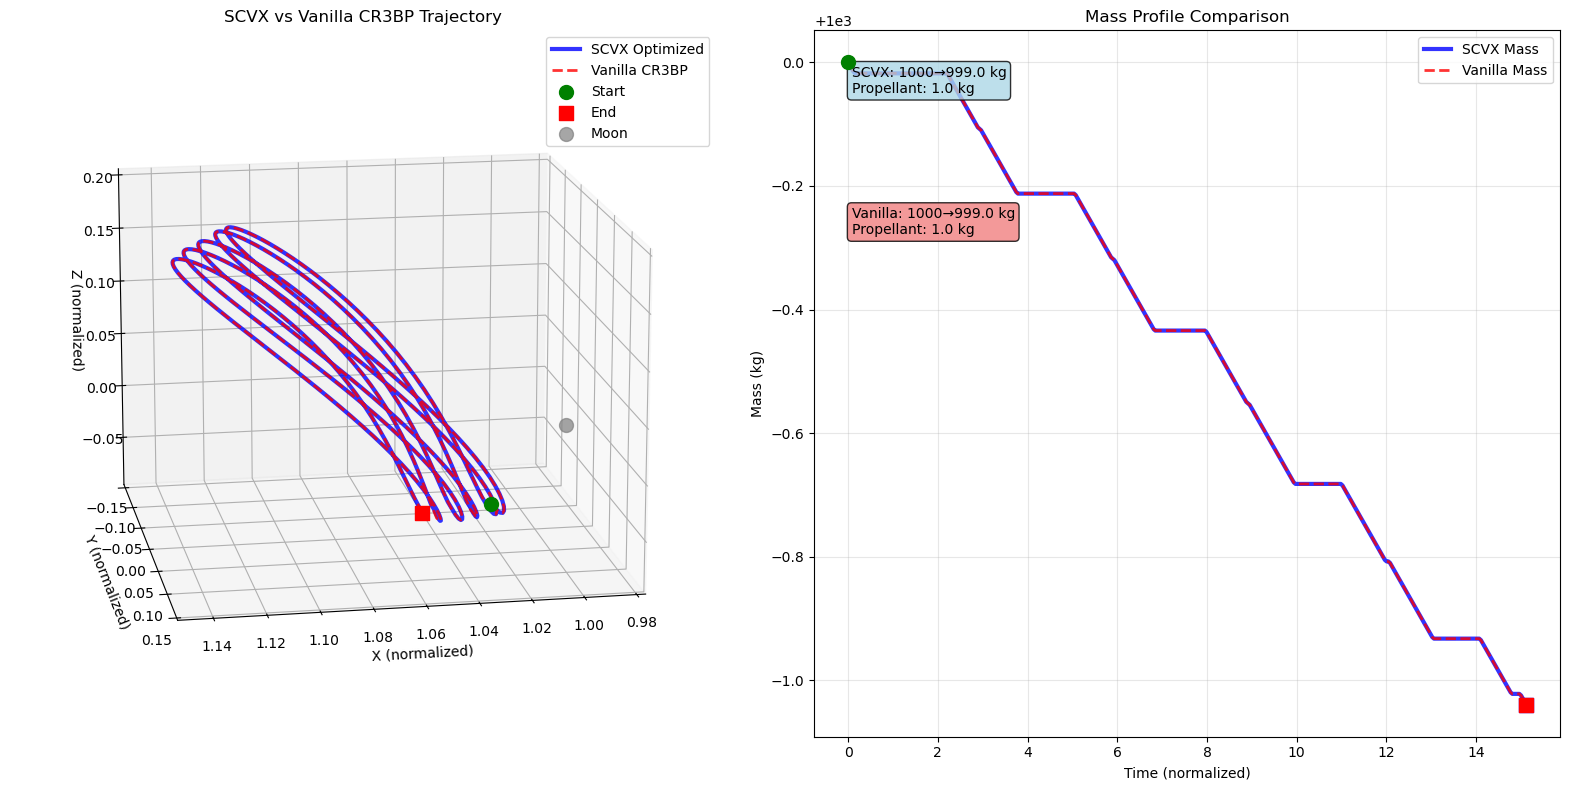

🎉 Trajectory comparison complete!
Max position difference: 2.68e-03


In [21]:
# SCVX vs Vanilla CR3BP Trajectory Comparison

print("🎯 SCVX vs Vanilla CR3BP Trajectory Comparison")

# Extract SCVX trajectory
scvx_trajectory = program.x.value.T  # Convert to (6, N) format
N_points = scvx_trajectory.shape[1]

# Time vector
dt_scvx = program.s.value
time_scvx = np.concatenate(([0], np.cumsum(dt_scvx)))*program.dt

# Transform tau to proper physical units
# Use tau (which contains direction and magnitude) with the physical transformation
scaling_factor = (np.exp(program.z_p) / 
                 np.concatenate([program.s.value, [program.s.value[-1]]]))
thrust_control = program.tau.value * scaling_factor[:, np.newaxis]

print(f"SCVX trajectory points: {N_points}")
print(f"Thrust control shape: {thrust_control.shape}")
print(f"Scaling factor shape: {scaling_factor.shape}")
print(f"Using tau with physical transformation")

# Initial conditions
x0_scvx = scvx_trajectory[:, 0]
m0_scvx = np.exp(program.z.value[0])

# Define vanilla ODE system with SCVX control
def vanilla_ode_with_control(t, state_mass):
    state = state_mass[:6]  # position and velocity
    mass = state_mass[6]    # mass = exp(z)
    
    control_vec = np.array([
        np.interp(t, time_scvx, thrust_control[:, 0]),  # x-component
        np.interp(t, time_scvx, thrust_control[:, 1]),  # y-component
        np.interp(t, time_scvx, thrust_control[:, 2])   # z-component
    ])

    # Get state derivative from vanilla dynamics
    state_dot = vanilla_cr3bp.state_dot(state, control_vec, mass)
    
    # Calculate mass derivative: dm/dt = -|control|/c
    control_mag = np.linalg.norm(control_vec)
    mass_dot = -(control_mag / c_val)
    return np.concatenate([state_dot, [mass_dot]])

# Integrate vanilla system with SCVX control using segmented approach

# Number of segments to break the integration into
n_segments = 5
segment_size = len(time_scvx) // n_segments
vanilla_trajectory_segments = []
vanilla_mass_segments = []


for seg in range(n_segments):
    # Determine segment indices
    start_idx = seg * segment_size
    if seg == n_segments - 1:
        end_idx = len(time_scvx) - 1  # Last segment includes all remaining points
    else:
        end_idx = (seg + 1) * segment_size
    
    # Get time range for this segment
    t_start = time_scvx[start_idx]
    t_end = time_scvx[end_idx]
    t_eval_segment = time_scvx[start_idx:end_idx+1]
    
    # Initial conditions for this segment
    if seg == 0:
        # First segment: always use SCVX initial conditions
        initial_state_segment = np.concatenate([scvx_trajectory[:, start_idx], [np.exp(program.z.value[start_idx])]])
    elif seg % 1 == 0:
        # Every 10th segment: reset to SCVX trajectory values to prevent drift
        initial_state_segment = np.concatenate([scvx_trajectory[:, start_idx], [np.exp(program.z.value[start_idx])]])
    else:
        # Other segments: use the last point from previous segment solution
        prev_trajectory = vanilla_trajectory_segments[-1]
        prev_mass = vanilla_mass_segments[-1]
        initial_state_segment = np.concatenate([prev_trajectory[:, -1], [prev_mass[-1]]])
    
    # Integrate this segment
    sol_segment = scipy.integrate.solve_ivp(
        vanilla_ode_with_control,
        [t_start, t_end],
        initial_state_segment,
        t_eval=t_eval_segment,
        rtol=1e-10,
    )
    
    if sol_segment.success:
        # Store segment results (skip first point for segments after the first to avoid duplication)
        if seg == 0:
            vanilla_trajectory_segments.append(sol_segment.y[:6, :])
            vanilla_mass_segments.append(sol_segment.y[6, :])
        else:
            vanilla_trajectory_segments.append(sol_segment.y[:6, 1:])  # Skip first point
            vanilla_mass_segments.append(sol_segment.y[6, 1:])        # Skip first point
    else:
        print(f"  ❌ Segment {seg+1} integration failed: {sol_segment.message}")
        break

# Combine all segments
if len(vanilla_trajectory_segments) == n_segments:
    vanilla_trajectory = np.concatenate(vanilla_trajectory_segments, axis=1)
    vanilla_mass = np.concatenate(vanilla_mass_segments)
    
    print(f"✅ All segments integrated successfully!")
    print(f"Combined trajectory shape: {vanilla_trajectory.shape}")
    print(f"Combined mass shape: {vanilla_mass.shape}")
    
    # Create a success flag for compatibility
    class SegmentedSolution:
        def __init__(self):
            self.success = True
    
    sol_vanilla = SegmentedSolution()
    
    # Compare final states
    scvx_final = scvx_trajectory[:, -1]
    vanilla_final = vanilla_trajectory[:, -1]
    position_error = np.linalg.norm(scvx_final[:3] - vanilla_final[:3])
    velocity_error = np.linalg.norm(scvx_final[3:] - vanilla_final[3:])
    
    print(f"Position error: {position_error:.2e} normalized = {position_error * LU:.3f} km")
    print(f"Velocity error: {velocity_error:.2e} normalized = {velocity_error * LU/TU:.6f} km/s")
    
    # Mass comparison
    scvx_final_mass = np.exp(program.z.value[-1])
    mass_error = abs(scvx_final_mass - vanilla_mass[-1])
    print(f"Mass error: {mass_error:.6f} kg ({mass_error/scvx_final_mass*100:.4f}%)")
    
    # Create subplot layout for trajectory and mass profile
    fig = plt.figure(figsize=(16, 8))
    
    # Plot 1: 3D Trajectory Comparison
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot trajectories
    ax1.plot(scvx_trajectory[0, :], scvx_trajectory[1, :], scvx_trajectory[2, :], 
            'b-', linewidth=3, label='SCVX Optimized', alpha=0.8)
    ax1.plot(vanilla_trajectory[0, :], vanilla_trajectory[1, :], vanilla_trajectory[2, :], 
            'r--', linewidth=2, label='Vanilla CR3BP', alpha=0.8)
    
    # Mark start and end points
    ax1.scatter(scvx_trajectory[0, 0], scvx_trajectory[1, 0], scvx_trajectory[2, 0], 
               c='green', s=100, marker='o', label='Start')
    ax1.scatter(scvx_trajectory[0, -1], scvx_trajectory[1, -1], scvx_trajectory[2, -1], 
               c='red', s=100, marker='s', label='End')
    
    # Plot celestial bodies
    # ax1.scatter([0], [0], [0], c='blue', s=200, alpha=0.7, label='Earth')
    ax1.scatter([1-mu_val], [0], [0], c='gray', s=100, alpha=0.7, label='Moon')
    
    ax1.set_xlabel('X (normalized)')
    ax1.set_ylabel('Y (normalized)')
    ax1.set_zlabel('Z (normalized)')
    ax1.set_title('SCVX vs Vanilla CR3BP Trajectory')
    ax1.legend()
    ax1.view_init(elev=15, azim=80)
    
    # Plot 2: Mass Profile Comparison
    ax2 = fig.add_subplot(122)
    
    # SCVX mass profile
    scvx_mass_profile = np.exp(program.z.value)
    ax2.plot(time_scvx, scvx_mass_profile, 'b-', linewidth=3, label='SCVX Mass', alpha=0.8)
    
    # Vanilla mass profile  
    ax2.plot(time_scvx, vanilla_mass, 'r--', linewidth=2, label='Vanilla Mass', alpha=0.8)
    
    # Mark initial and final masses
    ax2.scatter(time_scvx[0], scvx_mass_profile[0], c='green', s=100, marker='o', zorder=5)
    ax2.scatter(time_scvx[-1], scvx_mass_profile[-1], c='blue', s=100, marker='s', zorder=5)
    ax2.scatter(time_scvx[-1], vanilla_mass[-1], c='red', s=100, marker='s', zorder=5)
    
    # Add mass information text
    propellant_used_scvx = m0 -  scvx_mass_profile[-1]
    propellant_used_vanilla = m0 - vanilla_mass[-1]
    ax2.text(0.05, 0.95, f'SCVX: {m0:.0f}→{scvx_mass_profile[-1]:.1f} kg\nPropellant: {propellant_used_scvx:.1f} kg', 
             transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8), verticalalignment='top')
    ax2.text(0.05, 0.75, f'Vanilla: {m0:.0f}→{vanilla_mass[-1]:.1f} kg\nPropellant: {propellant_used_vanilla:.1f} kg', 
             transform=ax2.transAxes, bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.8), verticalalignment='top')
    
    ax2.set_xlabel('Time (normalized)')
    ax2.set_ylabel('Mass (kg)')
    ax2.set_title('Mass Profile Comparison')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"🎉 Trajectory comparison complete!")
    print(f"Max position difference: {np.max(np.linalg.norm(scvx_trajectory[:3, :] - vanilla_trajectory[:3, :], axis=0)):.2e}")
    
else:
    print(f"❌ Segmented vanilla integration failed!")